# Lab 4: Adding Trajectory Evaluations


In this lab, you will compute the convergence score of the agent, and you will use Phoenix experiments to set up this evaluation.

Here's how you will define the experiment components in this lab to compute the convergence score:



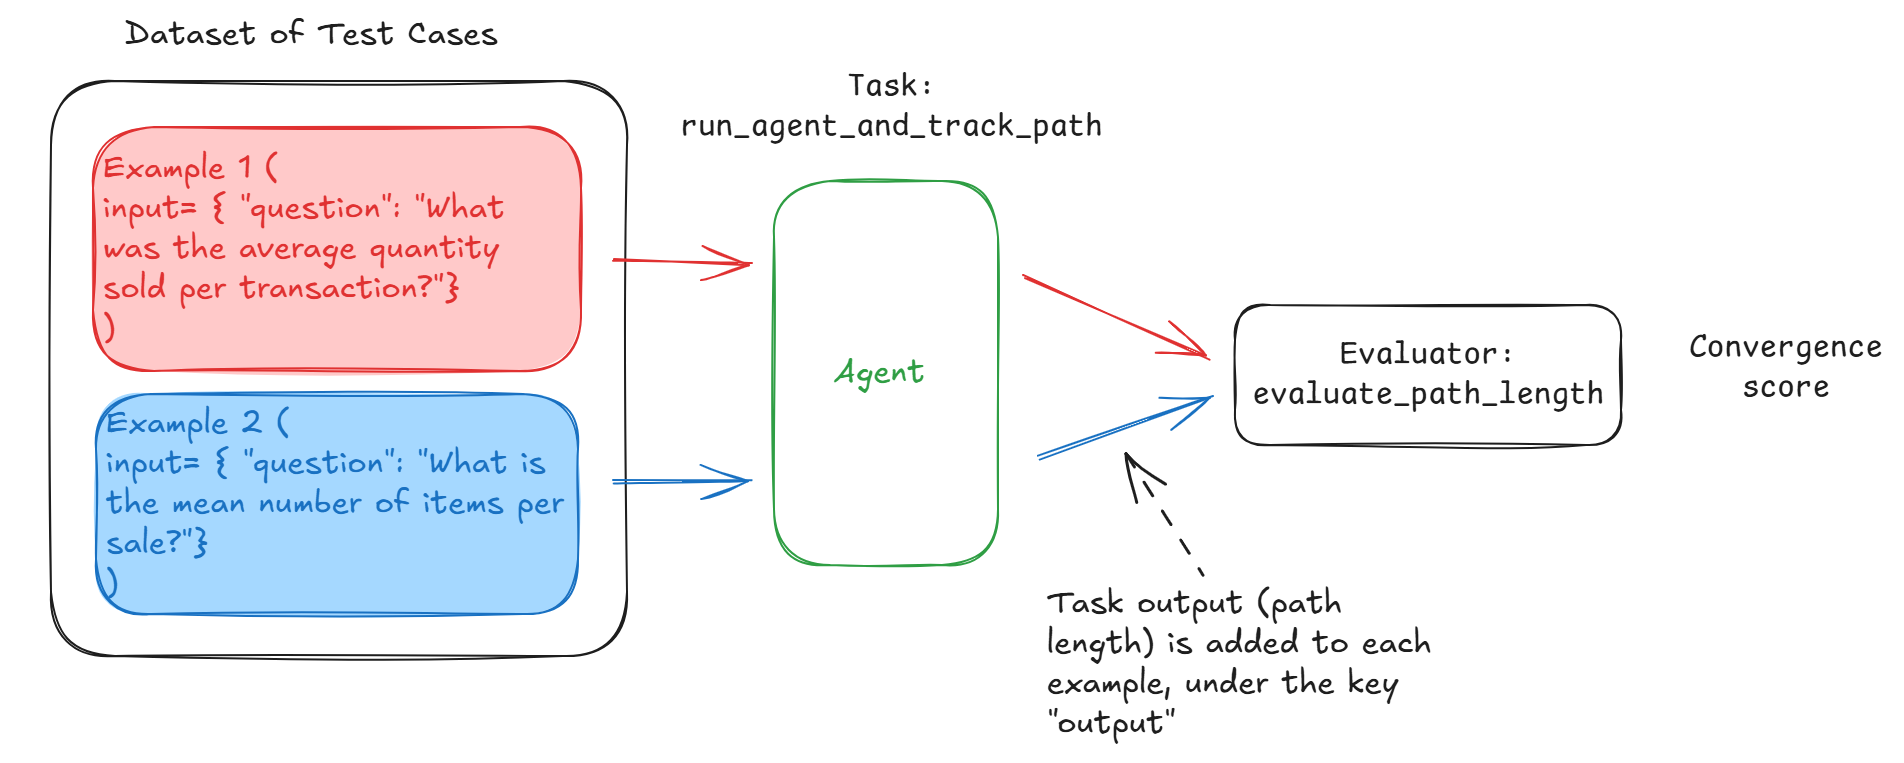

You will create a dataset of Phoenix examples where each example contains a different version of the same question. You will then create the task `run_agent_and_track_path` that you will use to run on each example and compute the path length. Finally, you will create the evaluator `evaluate_path_length` that computes the convergence score.

In [1]:
!uv pip install -q --upgrade arize-phoenix
!uv pip install -q --upgrade openinference-instrumentation-openai
!uv pip install -q python-dotenv openai duckdb

## Importing necessary libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import phoenix as px
from phoenix.evals import OpenAIModel
from phoenix.experiments import run_experiment, evaluate_experiment
from phoenix.experiments.types import Example
from phoenix.experiments.evaluators import create_evaluator
from phoenix.otel import register
import pandas as pd
from datetime import datetime
import os
import nest_asyncio
nest_asyncio.apply()

In [4]:
from utils import run_agent, get_phoenix_endpoint

OpenTelemetry Tracing Details
|  Phoenix Project: LLMEVALS
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## Creating the Dataset of Test Cases

In [5]:
px_client = px.Client()

In [6]:
convergence_questions = [
    "What was the average quantity sold per transaction?",
    "What is the mean number of items per sale?",
    "Calculate the typical quantity per transaction",
    "What's the mean transaction size in terms of quantity?",
    "On average, how many items were purchased per transaction?",
    "What is the average basket size per sale?",
    "Calculate the mean number of products per purchase",
    "What's the typical number of units per order?",
    "What is the average number of products bought per purchase?",
    "Tell me the mean quantity of items in a typical transaction",
    "How many items does a customer buy on average per transaction?",
    "What's the usual number of units in each sale?",
    "What is the typical amount of products per transaction?",
    "Show the mean number of items customers purchase per visit",
    "What's the average quantity of units per shopping trip?",
    "How many products do customers typically buy in one transaction?",
    "What is the standard basket size in terms of quantity?"
]

convergence_df = pd.DataFrame({
    'question': convergence_questions
})

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
dataset = px_client.upload_dataset(dataframe=convergence_df,
                                   dataset_name=f"convergence_questions-{now}",
                                   input_keys=["question"])

📤 Uploading dataset...
💾 Examples uploaded: http://127.0.0.1:6006/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==


### Link to Phoenix UI

You can open this link to check out the Phoenix UI and the uploaded dataset. You can use the same link to check out the results of the experiment you'll run in this notebook.

**Note**:
- Since each notebook of this course runs in an isolated environment, each notebook links to a different Phoenix server. This is why you won't see the projects you've worked on in the previous notebooks.
- Make sure that the notebook's kernel is running when checking the Phoenix UI. If the link does not open, it might be because the notebook has been open or inactive for a long time. In that case, make sure to refresh the browser, run all previous cells and then check this link.

In [7]:
print(get_phoenix_endpoint())

http://localhost:6006/v1/traces


## Creating the Task

In [8]:
# helper method to format the output returned by the task
def format_message_steps(messages):
    """
    Convert a list of message objects into a readable format that shows the steps taken.

    Args:
        messages (list): A list of message objects containing role, content, tool calls, etc.

    Returns:
        str: A readable string showing the steps taken.
    """
    steps = []
    for message in messages:
        role = message.get("role")
        if role == "user":
            steps.append(f"User: {message.get('content')}")
        elif role == "system":
            steps.append("System: Provided context")
        elif role == "assistant":
            if message.get("tool_calls"):
                for tool_call in message["tool_calls"]:
                    tool_name = tool_call["function"]["name"]
                    steps.append(f"Assistant: Called tool '{tool_name}'")
            else:
                steps.append(f"Assistant: {message.get('content')}")
        elif role == "tool":
            steps.append(f"Tool response: {message.get('content')}")

    return "\n".join(steps)

In [9]:
def run_agent_and_track_path(example: Example) -> dict:
    messages = [{"role": "user", "content": example.input.get("question")}]
    ret = run_agent(messages)

    # Ensure ret is a list of dicts
    if isinstance(ret, list) and all(isinstance(m, dict) for m in ret):
        return {
            "path_length": len(ret),
            "messages": format_message_steps(ret)
        }
    else:
        return {
            "path_length": 1,
            "messages": str(ret)
        }


## Running the Experiment

In [10]:
experiment = run_experiment(dataset,
                            run_agent_and_track_path,
                            experiment_name="Convergence Eval",
                            experiment_description="Evaluating the convergence of the agent")

🧪 Experiment started.
📺 View dataset experiments: http://127.0.0.1:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox


running tasks |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s

Running agent with messages: [{'role': 'user', 'content': 'What was the average quantity sold per transaction?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Running agent with messages: [{'role': 'user', 'content': 'What is the mean number of items per sale?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Running agent with messages: [{'role': 'user', 'content': 'Calculate the typical quantity per transaction'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Running agent with messages: [{'role': 'user', 'content': "What's the mean tra

In [11]:
experiment.as_dataframe()

,output,input,example_id
run_id,,,
RXhwZXJpbWVudFJ1bjoxNw==,"{'path_length': 1, 'messages': 'The standard b...",{'question': 'What is the standard basket size...,RGF0YXNldEV4YW1wbGU6MTc=
RXhwZXJpbWVudFJ1bjoxNg==,"{'path_length': 1, 'messages': 'Customers typi...",{'question': 'How many products do customers t...,RGF0YXNldEV4YW1wbGU6MTY=
RXhwZXJpbWVudFJ1bjoxNQ==,"{'path_length': 1, 'messages': 'The average qu...",{'question': 'What's the average quantity of u...,RGF0YXNldEV4YW1wbGU6MTU=
RXhwZXJpbWVudFJ1bjoxNA==,"{'path_length': 1, 'messages': 'The mean numbe...",{'question': 'Show the mean number of items cu...,RGF0YXNldEV4YW1wbGU6MTQ=
RXhwZXJpbWVudFJ1bjoxMw==,"{'path_length': 1, 'messages': 'The typical am...",{'question': 'What is the typical amount of pr...,RGF0YXNldEV4YW1wbGU6MTM=
RXhwZXJpbWVudFJ1bjoxMg==,"{'path_length': 1, 'messages': 'The usual numb...",{'question': 'What's the usual number of units...,RGF0YXNldEV4YW1wbGU6MTI=
RXhwZXJpbWVudFJ1bjoxMQ==,"{'path_length': 1, 'messages': 'On average, a ...",{'question': 'How many items does a customer b...,RGF0YXNldEV4YW1wbGU6MTE=
RXhwZXJpbWVudFJ1bjoxMA==,"{'path_length': 1, 'messages': 'The mean quant...",{'question': 'Tell me the mean quantity of ite...,RGF0YXNldEV4YW1wbGU6MTA=
RXhwZXJpbWVudFJ1bjo5,"{'path_length': 1, 'messages': 'The average nu...",{'question': 'What is the average number of pr...,RGF0YXNldEV4YW1wbGU6OQ==


## Evaluating the Path

In [12]:
outputs = experiment.as_dataframe()["output"].to_dict().values()

# Will include the user and system messages
optimal_path_length = min(output.get('path_length') for output in outputs if output and output.get('path_length') is not None)
print(f"The optimal path length is {optimal_path_length}")

The optimal path length is 1


In [13]:
@create_evaluator(name="Convergence Eval", kind="CODE")
def evaluate_path_length(output: str) -> float:
    if output and output.get("path_length"):
        return optimal_path_length/float(output.get("path_length"))
    else:
        return 0

In [14]:
experiment = evaluate_experiment(experiment,
                            evaluators=[evaluate_path_length])

🧠 Evaluation started.


running experiment evaluations |          | 0/17 (0.0%) | ⏳ 00:00<? | ?it/s


🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (10/23/25 02:50 PM +0530)
--------------------------------------------
          evaluator   n  n_scores  avg_score
0  Convergence Eval  17        17        1.0

Tasks Summary (10/23/25 02:50 PM +0530)
---------------------------------------
   n_examples  n_runs  n_errors
0          17      17         0
